In [2]:
%matplotlib inline
import sys
sys.path.append("src") # add the source dir

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from src.pipeline import Pipeline, MultiPipeline
from mne_bids import BIDSPath
import mne

We will do an individual Analysis of subject 30, afterthat, we will statistically test all the other subjects

In [4]:
#set bids path
bids_root = os.path.join('data', 'P3')
bids_path = BIDSPath(subject='030', session='P3', task='P3',datatype='eeg', suffix='eeg', root=bids_root)
pipeline = Pipeline(bids_path)

In [5]:
from preprocessing import CleaningData, SimpleMNEFilter, PrecomputedICA

pipeline.load_data()
pipeline.set_montage()
pipeline.set_custom_events_mapping(task='P3') # mapping for P3 task

INFO:root:Loading Data
INFO:root:Standard 1020 montage and EOG channels are set


### We will use our pipeline to perform following operations
- Loading bad segments, bad channels
- Apply filtering
- Loading Precomputed ICA

In [6]:
pipeline.make_pipeline([SimpleMNEFilter(.5, 50, 'firwin'), CleaningData(bids_path), PrecomputedICA(bids_path)])

INFO:root:*****Proceesing for subject: 030*****
INFO:root:Applying filtering
INFO:root:Applying cleaning
INFO:root:Applying ICA
INFO:root:Processed subject 030



In [7]:
# We take the values below based on the erp core paper https://doi.org/10.1016/j.neuroimage.2020.117465
pipeline.apply_rereferencing(['P9', 'P10'])
pipeline.apply_resampling(256)

INFO:root:Applying re-referencing
INFO:root:Applying resampling


# ERP Peak Analysis for subject 30

In [8]:
from erpanalysis import ERPAnalysis
# Although in the erp paper, Authors mentions about cutting the epochs from (-0.2, 0.8) 
# and keeping baseline from (-200, 0), we have decided not to proced with these value and rather use our own baseline and time window
tmin = -0.1
tmax = 0.8
baseline = (None, 0)


## We will create epochs from custom mappings. We have 

- Stimulus: A, B, C, D, E

- Conditions: Rare, Frequent

In [9]:
# we will use our own class for performing peak analysis. The classes encapsulates the MNE.epochs class and has few other functions
erp = ERPAnalysis(tmin, tmax)
erp.compute_epochs(pipeline.raw, pipeline.events, pipeline.event_ids, baseline=baseline, reject_by_annotation=True)

<Epochs |  295 events (all good), -0.101562 - 0.800781 sec, baseline -0.101562 – 0 sec, ~17.3 MB, data loaded,
 'response/correct/201': 145
 'response/error/202': 4
 'stimulus/A/freq/12': 4
 'stimulus/A/freq/13': 6
 'stimulus/A/freq/14': 8
 'stimulus/A/freq/15': 7
 'stimulus/A/rare/11': 5
 'stimulus/B/freq/21': 6
 'stimulus/B/freq/23': 10
 'stimulus/B/freq/24': 3
 'stimulus/B/freq/25': 8
 'stimulus/B/rare/22': 8
 'stimulus/C/freq/31': 7
 'stimulus/C/freq/32': 9
 'stimulus/C/freq/34': 4
 'stimulus/C/freq/35': 10
 'stimulus/C/rare/33': 7
 'stimulus/D/freq/41': 5
 'stimulus/D/freq/42': 5
 'stimulus/D/freq/43': 3
 'stimulus/D/freq/45': 0
 'stimulus/D/rare/44': 4
 'stimulus/E/freq/51': 4
 'stimulus/E/freq/52': 9
 'stimulus/E/freq/53': 3
 'stimulus/E/freq/54': 5
 'stimulus/E/rare/55': 6>

## Analysis Epochs

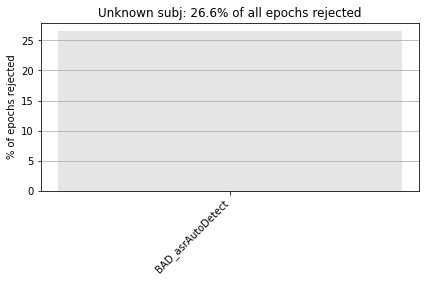

In [11]:
# based on the BAD annotations found using autoreject, we rejected 26,6% of all our epochs
erp.epochs.plot_drop_log();

In [12]:
# get the rare and frequent epochs - rare represents the target and frequent represents the distractor
rare_epochs = erp.epochs['rare']
freq_epochs = erp.epochs['freq']

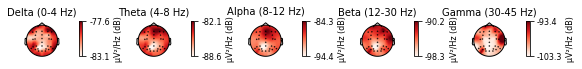

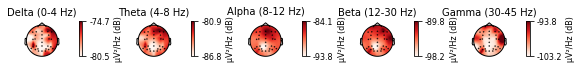

In [13]:
_, axs = plt.subplots(nrows=1, ncols=5, figsize=(8, 4));
rare_epochs.plot_psd_topomap(axes = axs);
_, axs = plt.subplots(nrows=1, ncols=5, figsize=(8, 4));
freq_epochs.plot_psd_topomap(axes = axs);

We see differences in Delta and Theta, which seems correct for P300 and also discussed in [1]

[1] Güntekin B, Başar E. A new interpretation of P300 responses upon analysis of coherences. Cogn Neurodyn. 2010;4(2):107-118. doi:10.1007/s11571-010-9106-0

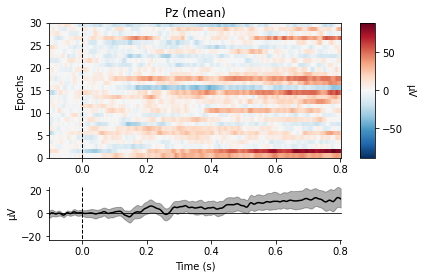

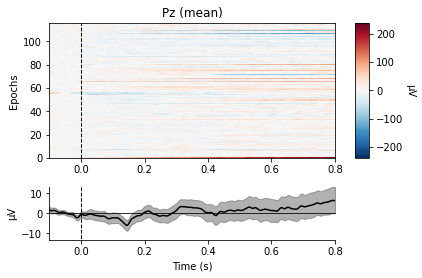

In [11]:
rare_epochs.plot_image(picks=['Pz'], combine='mean');
freq_epochs.plot_image(picks=['Pz'], combine='mean');

The ERP images seems correct - we have some activity happening around 400-600ms for rare epochs. Though, ideally it should be around 300-400ms

## Analysis Evokeds

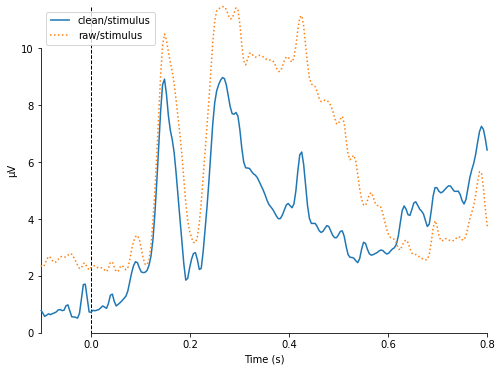

[<Figure size 576x432 with 1 Axes>]

In [12]:
epochs_raw = erp.compute_epochs(pipeline.raw, pipeline.events, pipeline.event_ids, set_default=False, reject_by_annotation=False)
epochs_clean = erp.epochs.copy()
evoked_raw = epochs_raw['stimulus'].average()
evoked_clean = epochs_clean['stimulus'].average()
mne.viz.plot_compare_evokeds({'clean/stimulus': evoked_clean,'raw/stimulus': evoked_raw},  linestyles=['-', ':'], ci=.95)

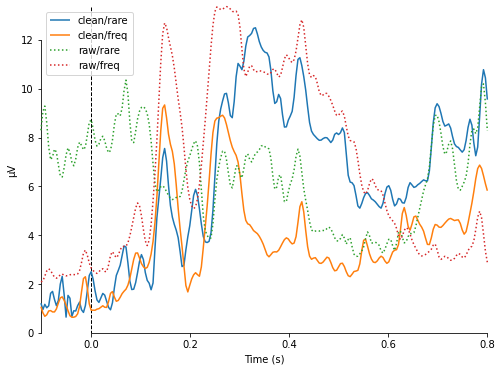

[<Figure size 576x432 with 1 Axes>]

In [13]:
mne.viz.plot_compare_evokeds({'clean/rare': epochs_clean['rare'].average(),
'clean/freq': epochs_clean['freq'].average(),
'raw/rare':epochs_raw['rare'].average(),
'raw/freq': epochs_raw['freq'].average(),
}, linestyles=['-', '-', ':', ':'])

We can see a significant difference between the rare and freq events around 300-400 ms which is what we were looking for.

In [14]:
evoked_rare = epochs_clean['rare'].average()
evoked_freq = epochs_clean['freq'].average()

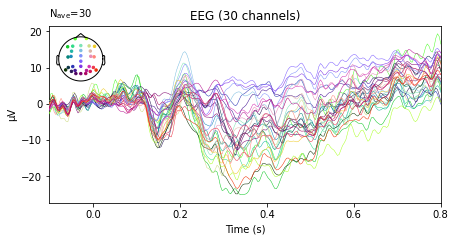

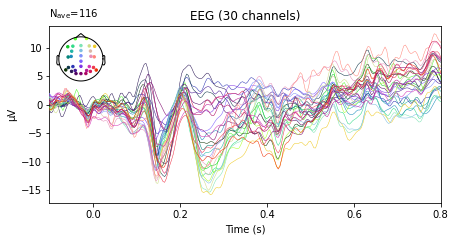

In [15]:
evoked_rare.plot(spatial_colors=True);
evoked_freq.plot(spatial_colors=True);

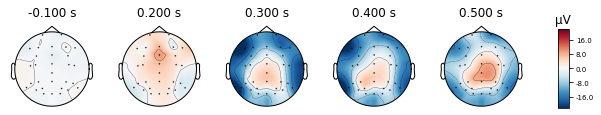

In [16]:
evoked_rare.plot_topomap(times=[-0.1, 0.2, 0.3, 0.4, 0.5], average=0.05);

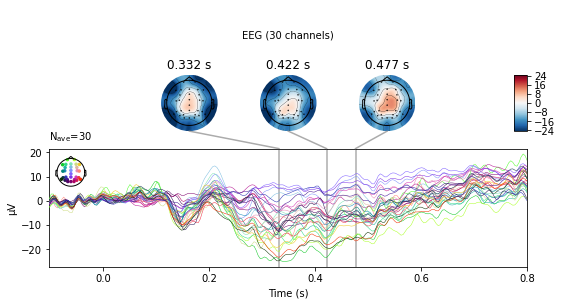

In [17]:
evoked_rare.plot_joint();

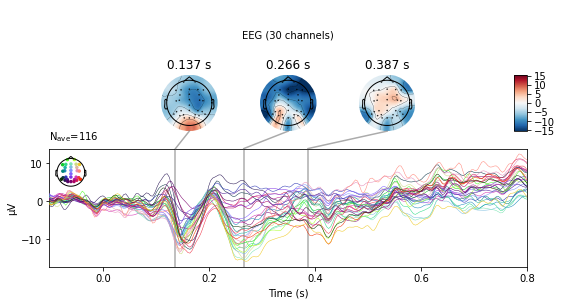

In [18]:
evoked_freq.plot_joint();

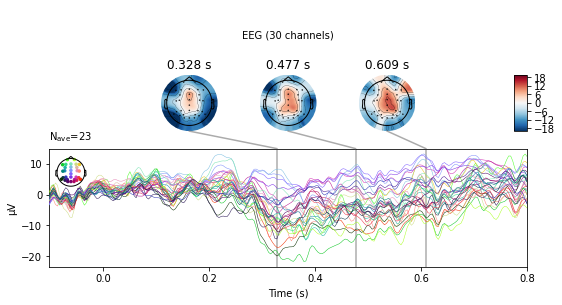

In [19]:
rare_minus_freq = mne.combine_evoked([evoked_rare, evoked_freq], weights=[1, -1])
rare_minus_freq.plot_joint();

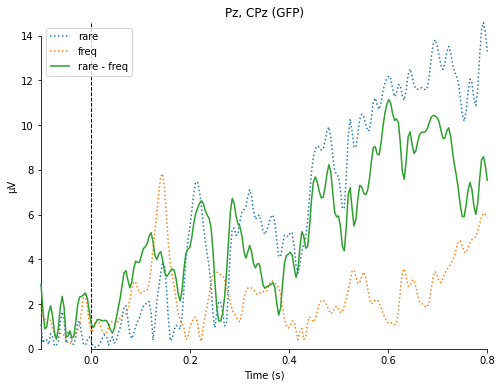

[<Figure size 576x432 with 1 Axes>]

In [20]:
(mne.viz.plot_compare_evokeds(
    {'rare': evoked_rare,'freq': evoked_freq, 'rare - freq': rare_minus_freq},
    picks=["Pz", "CPz"], linestyles=['dotted', 'dotted', 'solid']))

## It seems it is futile to check for condition on each subject since, the number of events in epochs drop downs to a range between 0,5. There is a possiblity that we might be getting futile results

## ERP Peak Analysis for all subjects

In [21]:
pipelines = MultiPipeline(bids_root)
erp = ERPAnalysis(tmin, tmax, baseline=(None, 0), reject_by_annotation=True, all_subjects=True)
pipelines.start_erp_analysis(erp);

100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


In [22]:
len(erp.epochs)

40

## Pipeline Check:

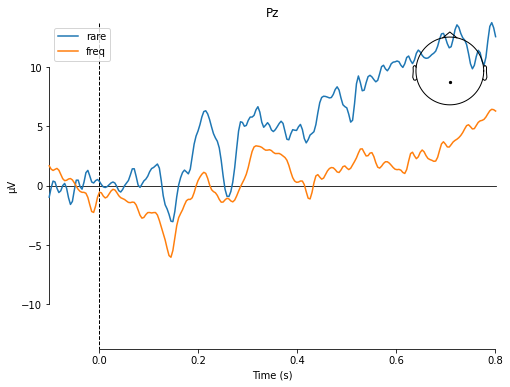

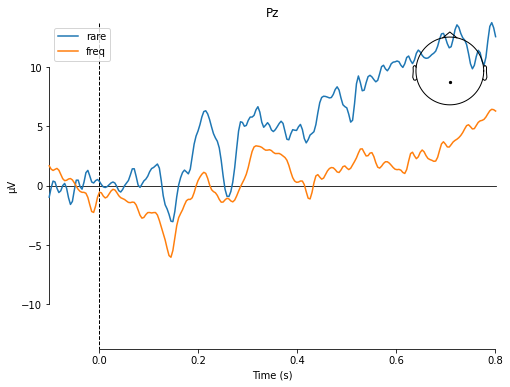

[<Figure size 576x432 with 2 Axes>]

In [24]:
mne.viz.plot_compare_evokeds({'rare': erp.epochs[29]['rare'].average(),'freq':erp.epochs[29]['freq'].average()},picks="Pz")
mne.viz.plot_compare_evokeds({'rare': epochs_clean['rare'].average(),'freq':epochs_clean['freq'].average()},picks="Pz")

### We will plot the combine evoked for all the subjects

In [ ]:
rare_all = mne.combine_evoked([epochs['rare'].average() for epochs in erp.epochs])
freq_all = mne.combine_evoked([epochs['freq'].average() for epochs in erp.epochs])

In [ ]:
mne.viz.plot_compare_evokeds({'rare': rare_all,'freq': freq_all}, picks="Pz")

# ERP Peak Analysis

`rare_peaks_df` and `freq_peaks_df` contains ERP peaks of all trials

While MNE `evoked.get_peak()` is useful in finding the location and latency of peak amplitude using the time window provided, it lacks providing support for picking specific channels and mean amplitude values. We reject 30% of the lower values and 30% of the higer values

Therefore, we will be using our own function for peak value calculation. To get a robust mean amplitude we take a `winsorize` mean to reduce the effect of possibly spurious outliers by limiting the extreme values.

Reference: https://erpinfo.org/blog/2018/7/5/mean-versus-peak-amplitude

In [28]:
rare_peaks_df = erp.compute_peak('rare', 0.3, 0.1, ['Pz'], 'pos')
freq_peaks_df = erp.compute_peak('freq', 0.3, 0.1, ['Pz'], 'pos')

For example, ERP peaks for Subject 39

In [29]:
rare_peaks_df[29].describe()

peak_amp   mean_amp     latency      trial
count  30.000000  30.000000   30.000000  30.000000
mean   17.133333   4.266667  284.866667  14.500000
std    15.584549  13.511000   69.022102   8.803408
min   -22.000000 -30.000000  199.000000   0.000000
25%     9.000000  -3.750000  215.000000   7.250000
50%    14.000000   5.500000  291.000000  14.500000
75%    29.500000  12.000000  347.250000  21.750000
max    43.000000  29.000000  395.000000  29.000000

In [30]:
freq_peaks_df[29].describe()

peak_amp    mean_amp     latency       trial
count  116.000000  116.000000  116.000000  116.000000
mean    14.120690    1.034483  306.982759   57.500000
std     20.061711   18.925911   63.362173   33.630343
min    -48.000000  -62.000000  199.000000    0.000000
25%      4.000000   -7.000000  248.000000   28.750000
50%     14.000000    1.000000  322.000000   57.500000
75%     21.000000    8.000000  355.000000   86.250000
max    134.000000  108.000000  395.000000  115.000000

## Now we will take the difference of conditions for each subject by calculating `rare_peaks_df` - `rare_peaks_df` and perform t-test

Performing t-test at individual subject level

In [31]:
from scipy import stats
dfg, peak_p_values, mean_p_values, average_rare_amplitude, average_freq_amplitude = [], [], [], [], []
for rare_df, freq_df in zip(rare_peaks_df, freq_peaks_df):
    inval_col = ['trial', 'stimulus', 'condition', 'channel']
    peak_p_values.append(stats.ttest_ind(rare_df['peak_amp'], freq_df['peak_amp'])[1])
    mean_p_values.append(stats.ttest_ind(rare_df['mean_amp'], freq_df['mean_amp'])[1])
    average_rare_amplitude.append(rare_df.mean()[0])
    average_freq_amplitude.append(freq_df.mean()[0])
    dfg.append(rare_df.drop(inval_col, axis=1).subtract(freq_df.drop(inval_col, axis=1)))

<AxesSubplot:ylabel='Count'>

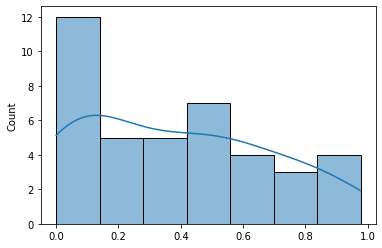

In [32]:
# _, axs = plt.subplots(nrows=1, ncols=2, figsize=(4, 3)); #doesn;t work because of %matplotlib inline
sns.histplot(peak_p_values, kde=True)

<AxesSubplot:ylabel='Count'>

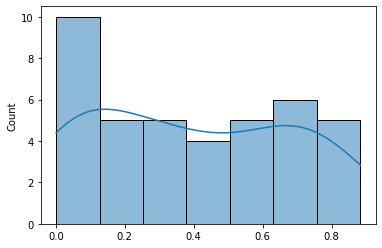

In [33]:
sns.histplot(mean_p_values, kde=True)

In [34]:
dfg[39].describe()

peak_amp    mean_amp     latency
count  35.000000   35.000000   35.000000
mean    1.914286    0.371429   -1.342857
std    25.062711   27.219247   90.264625
min   -99.000000 -124.000000 -184.000000
25%    -6.000000   -6.500000  -74.500000
50%     1.000000    2.000000   20.000000
75%    17.000000   16.500000   49.000000
max    33.000000   38.000000  176.000000

### Maximum peak amplitude and mean peak amplitude for difference in condiitons [rare - freq]

In [35]:
import pandas as pd
rp_dict = {'sub': [], 'peak_amplitude': [], 'mean_peak_amplitude':[], 'latency': []}
for subj in range(1, len(dfg)+1):
    ttre = dfg[subj-1].mean()
    rp_dict['sub'].append('Sub {}'.format(subj))
    rp_dict['peak_amplitude'].append(ttre[0])
    rp_dict['mean_peak_amplitude'].append(ttre[1])
    rp_dict['latency'].append(ttre[2])
rp_df = pd.DataFrame.from_dict(rp_dict)
rp_df

sub  peak_amplitude  mean_peak_amplitude    latency
0    Sub 1        0.971429             0.514286  -9.000000
1    Sub 2        2.575000             1.825000   9.475000
2    Sub 3        3.314286             2.000000 -20.685714
3    Sub 4        1.800000             0.966667  -1.933333
4    Sub 5        0.125000            -0.050000 -19.175000
5    Sub 6        6.000000             5.350000 -15.250000
6    Sub 7        3.794118             2.205882 -24.529412
7    Sub 8        1.818182             2.227273  -0.227273
8    Sub 9        1.200000             1.533333 -15.733333
9   Sub 10       -2.166667            -1.888889  -2.722222
10  Sub 11        0.825000             0.375000  -7.925000
11  Sub 12        1.225000             1.550000  -0.100000
12  Sub 13        0.487179             0.153846  11.717949
13  Sub 14       -3.545455            -2.863636   9.681818
14  Sub 15       -0.512821            -0.358974 -39.564103
15  Sub 16       -1.175000            -0.800000  13.275000
16  Sub 17        2.179487             2.076923  -4.564103
17  Sub 18        0.710526             0.842105  11.157895
18  Sub 19       -1.100000            -0.550000 -30.525000
19  Sub 20        1.250000             0.700000 -19.450000
20  Sub 21       -3.533333            -5.266667  16.066667
21  Sub 22        0.552632             0.052632  -3.394737
22  Sub 23        0.111111            -0.888889  20.388889
23  Sub 24        0.000000             0.000000  -8.583333
24  Sub 25        2.263158             1.684211  10.736842
25  Sub 26        0.875000            -0.525000  23.325000
26  Sub 27       -0.050000            -0.400000   7.975000
27  Sub 28       -1.424242            -1.181818 -19.787879
28  Sub 29       -3.432432            -3.081081 -13.837838
29  Sub 30        2.233333             1.400000 -29.333333
30  Sub 31        0.758621             0.379310  21.172414
31  Sub 32        0.975000             1.575000 -17.475000
32  Sub 33        2.525000             2.475000  -3.650000
33  Sub 34       -0.270270            -0.108108  23.756757
34  Sub 35        3.518519             3.185185 -15.444444
35  Sub 36       -0.105263             0.394737 -43.078947
36  Sub 37        2.250000             2.200000 -18.950000
37  Sub 38       -0.600000            -0.257143 -21.257143
38  Sub 39       -0.475000            -1.625000   9.025000
39  Sub 40        1.914286             0.371429  -1.342857

T- Test for all subjects by taking average

In [36]:
# average_rare_amplitude
stats.ttest_ind(average_rare_amplitude, average_freq_amplitude)

Ttest_indResult(statistic=0.7679075298332746, pvalue=0.4448606695012677)

Ideally we were expecting a value less the 0.1 or 0.2


But based on what we have, we can't reject the null hypothesis that there is a significant difference between conditions `rare` and `freq`

### Let's calculate T-test again without taking average

In [37]:
rare_df = pd.concat(rare_peaks_df, ignore_index=True)
freq_df = pd.concat(freq_peaks_df, ignore_index=True)
rare_df.describe()

peak_amp     mean_amp      latency        trial
count  1370.000000  1370.000000  1370.000000  1370.000000
mean      6.965693     0.194891   304.693431    17.429197
std       6.978386     6.498579    68.428554    10.914223
min     -82.000000  -112.000000   199.000000     0.000000
25%       3.000000    -3.000000   234.000000     8.000000
50%       6.000000     0.000000   312.000000    17.000000
75%      10.000000     3.000000   371.000000    26.000000
max      46.000000    32.000000   395.000000    39.000000

In [38]:
freq_df.describe()

peak_amp     mean_amp      latency        trial
count  5463.000000  5463.000000  5463.000000  5463.000000
mean      6.433828    -0.278785   307.794252    71.217646
std       6.702877     6.150505    68.420661    43.832414
min     -58.000000  -101.000000   199.000000     0.000000
25%       3.000000    -3.000000   238.000000    34.000000
50%       6.000000     0.000000   320.000000    68.000000
75%       9.000000     3.000000   371.000000   108.000000
max     134.000000   108.000000   395.000000   159.000000

### T- Test for all subjects without taking average

In [39]:
stats.ttest_ind(rare_df['mean_amp'], freq_df['mean_amp'])

Ttest_indResult(statistic=2.5196084706155606, pvalue=0.01177116612660162)

### Seems like our p-value is improved. It is 0.01 which is less than 0.05. Hence, we can say there is a significant difference between rare and freq stimulus

In [40]:
peak_df = pd.concat([rare_df, freq_df], ignore_index=True)

## We will further do some plotting to see if we are missing something

### Plotting only on condition: `Rare`, `Freq`

<AxesSubplot:xlabel='latency', ylabel='Density'>

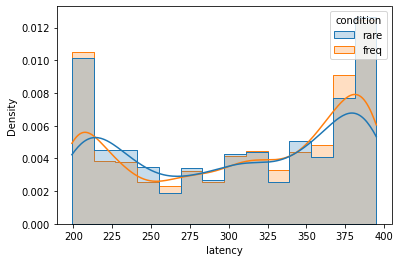

In [41]:
import seaborn as sns
sns.histplot(peak_df, x='latency', hue='condition', kde=True, element="step",
    stat="density", common_norm=False)

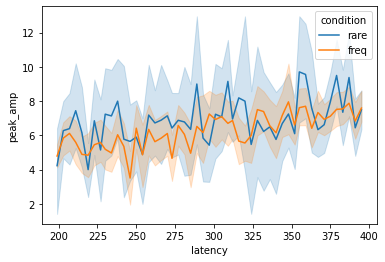

In [42]:
ax = sns.lineplot(x="latency", y="peak_amp", data=peak_df, hue='condition')

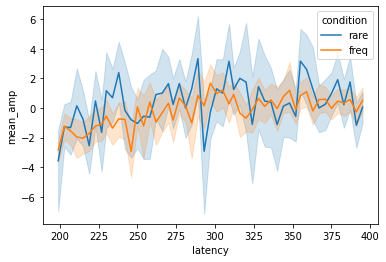

In [43]:
ax = sns.lineplot(x="latency", y="mean_amp", data=peak_df, hue='condition')

<AxesSubplot:xlabel='peak_amplitude', ylabel='mean_peak_amplitude'>

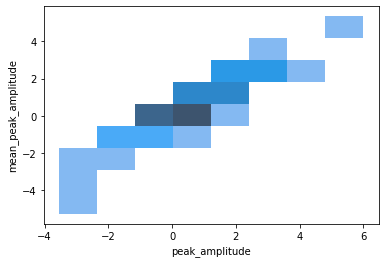

In [44]:
sns.histplot(data=rp_df, x='peak_amplitude', y='mean_peak_amplitude')

## Let's see for both condition [rare, freq] and stimulus [A, B, C, D, E]

In [45]:
A_rare_peaks = pd.concat(erp.compute_peak('A/rare', 0.3, 0.1, ['Pz', 'Cpz']), ignore_index=True)
A_freq_peaks = pd.concat(erp.compute_peak('A/freq', 0.3, 0.1, ['Pz', 'Cpz']), ignore_index=True)
B_rare_peaks = pd.concat(erp.compute_peak('B/rare', 0.3, 0.1, ['Pz', 'Cpz']), ignore_index=True)
B_freq_peaks = pd.concat(erp.compute_peak('B/freq', 0.3, 0.1, ['Pz', 'Cpz']), ignore_index=True)
C_rare_peaks = pd.concat(erp.compute_peak('C/rare', 0.3, 0.1, ['Pz', 'Cpz']), ignore_index=True)
C_freq_peaks = pd.concat(erp.compute_peak('C/freq', 0.3, 0.1, ['Pz', 'Cpz']), ignore_index=True)
D_rare_peaks = pd.concat(erp.compute_peak('D/rare', 0.3, 0.1, ['Pz', 'Cpz']), ignore_index=True)
D_freq_peaks = pd.concat(erp.compute_peak('D/freq', 0.3, 0.1, ['Pz', 'Cpz']), ignore_index=True)
E_rare_peaks = pd.concat(erp.compute_peak('E/rare', 0.3, 0.1, ['Pz', 'Cpz']), ignore_index=True)
E_freq_peaks = pd.concat(erp.compute_peak('E/freq', 0.3, 0.1, ['Pz', 'Cpz']), ignore_index=True)


We will contact all of them

In [46]:
all_peaks = pd.concat([
A_rare_peaks,
A_freq_peaks,
B_rare_peaks,
B_freq_peaks,
C_rare_peaks,
C_freq_peaks,
D_rare_peaks,
D_freq_peaks,
E_rare_peaks,
E_freq_peaks,
], ignore_index=True)

[(-50.0, 50.0)]

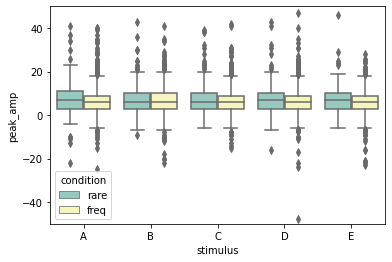

In [47]:
ax = sns.boxplot(x="stimulus", y="peak_amp", hue="condition",  data=all_peaks, palette="Set3")
ax.set(ylim=(-50, 50))

[(-50.0, 50.0)]

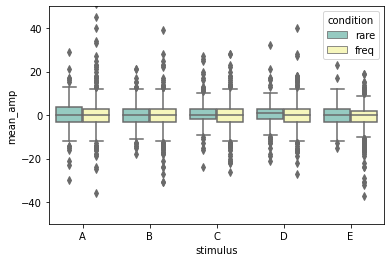

In [48]:
ax = sns.boxplot(x="stimulus", y="mean_amp", hue="condition",  data=all_peaks, palette="Set3")
ax.set(ylim=(-50, 50))

From the plots above, we see a very small difference between the mean and peak amplitude for rare and freq stimulus. Idealy, we wan to see the mean and peak amplitudes of rare stimulus higher than the freq stimulus

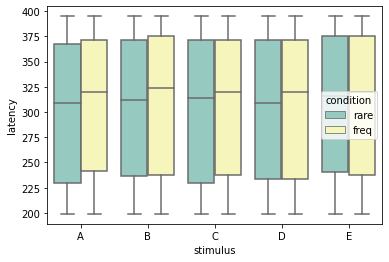

In [49]:
ax = sns.boxplot(x="stimulus", y="latency", hue="condition",  data=all_peaks, palette="Set3")

It is strange to observe that `rare/target` events have low mean latency than `freq/distractor` events for all stimulus

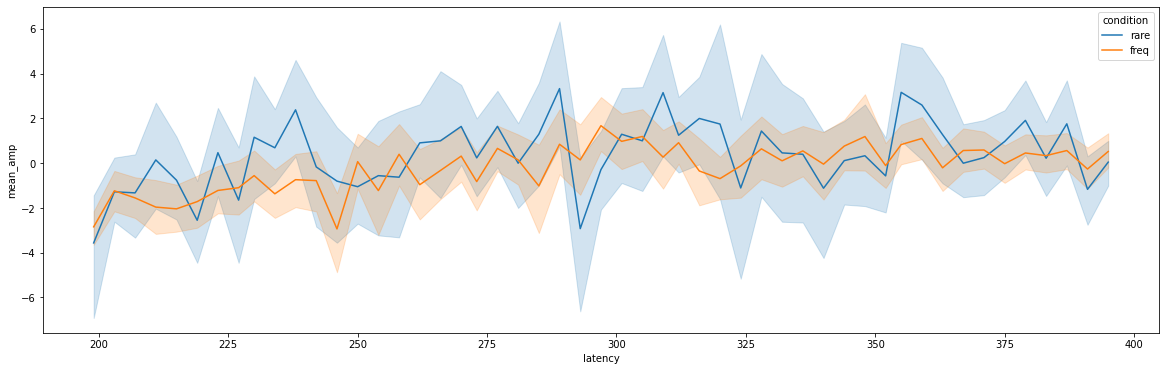

In [50]:
_, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 6));
axs = sns.lineplot(x="latency", y="mean_amp", data=all_peaks, hue='condition')

The voltage drop around 300ms seems quite strange for rare stimulus!

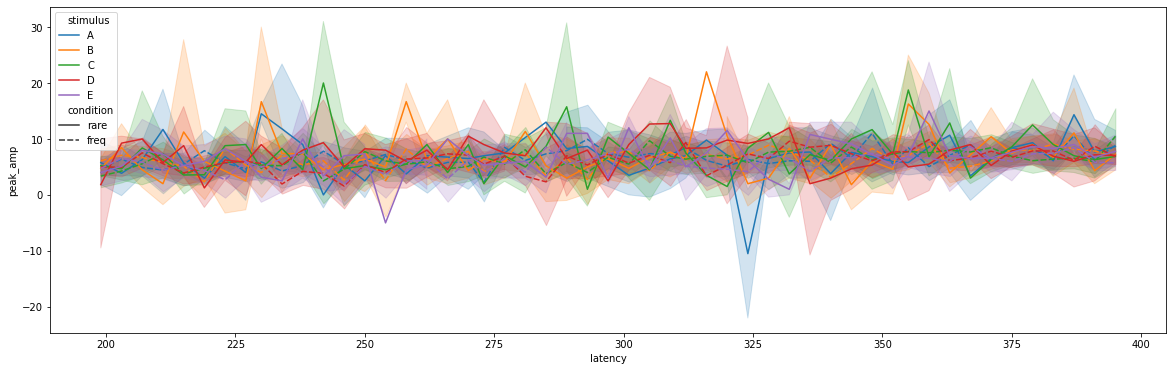

In [51]:
_, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 6));
axs = sns.lineplot(x="latency", y="peak_amp", data=all_peaks, hue='stimulus', style="condition")

## TO see whether stimulus A, B, C, D are independent, we will plot their distribution

<AxesSubplot:xlabel='mean_amp', ylabel='Density'>

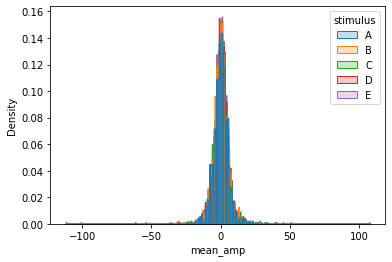

In [52]:
sns.histplot(
    all_peaks, x="mean_amp", hue="stimulus", element="step",
    stat="density", common_norm=False,
)

<AxesSubplot:xlabel='peak_amp', ylabel='Density'>

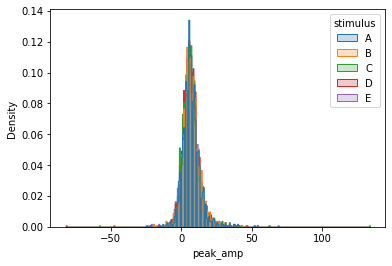

In [53]:
sns.histplot(
    all_peaks, x="peak_amp", hue="stimulus", element="step",
    stat="density", common_norm=False
    )